<a href="https://colab.research.google.com/github/inhovation97/Get-an-education-Computer-Vision/blob/main/Image%20Segmentation/ResUnet_tutorial_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98softmax_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, Multiply, GlobalAveragePooling2D,Reshape, Dense
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Concatenate

import glob
import random
import cv2
from random import shuffle

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annota

# Generators

In [ ]:
def image_generator(files, batch_size = 16, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'annotations/trimaps/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))

        #preprocess the mask 
        mask[mask >= 2] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)

    batch_y = to_categorical(batch_y)
    # (20, 256, 256, 1) --> (20, 256, 256, 2)

    yield (batch_x, batch_y)      
    

In [ ]:
batch_size = 16 

all_files = os.listdir('images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(train_generator)

In [ ]:
print (x.shape, y.shape)

(16, 256, 256, 3) (16, 256, 256, 2)


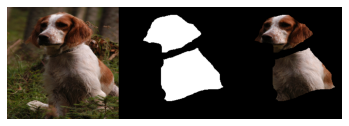

In [ ]:
plt.axis('off')
img = x[0]
# img (256, 256, 3)
msk = y[0]
# mask (256, 256, 2)

msk = msk[:,:,1]
# msk[:,:,0] --> 배경이 1, 물체가 0
# msk[:,:,1] --> 배경이 0, 물체가 1
# msk (256, 256, 2) -> (256, 256)

msk = np.stack((msk,)*3, axis=-1)
plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $x_{true}, x_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_pred = K.argmax(y_pred, axis=-1)
    y_true = y_true[:,:,:,1]
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = K.cast(y_true_f, 'float32')
    y_pred_f = K.cast(y_pred_f, 'float32')
    
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [ ]:
# 교집합/합집합 -> 예측, 정답segmentation 영역의 합집합으로 겹치는 픽셀부분을 나눈 것임
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32') # binary로 했기 때문에 0.5 임계값
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou # loss func으로 쓰일 수 있다.

In [ ]:
def block_residual(x, nKernels):
  # (n, 256, 256, 8)
  identity = x
  # (n, 256, 256, 8)

  x = BatchNormalization()(x)
  # (n, 256, 256, 8)
  x = Activation('relu')(x)
  # (n, 256, 256, 8)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  # (n, 256, 256, 8)

  x = BatchNormalization()(x)
  # (n, 256, 256, 8)
  x = Activation('relu')(x)
  # (n, 256, 256, 8)
  x = Conv2D(nKernels, 3, activation=None, kernel_initializer='he_normal', padding='same')(x)
  # (n, 256, 256, 8)

  # (n, 256, 256, 8) + # (n, 256, 256, 8)
  return x + identity


In [ ]:
def dense_block(x0, growth_rate=4):

  x1 = conv_block(x0, growth_rate)
  x1c = Concatenate(axis=-1)([x0, x1])

  x2 = conv_block(x1c, growth_rate)
  x2c = Concatenate(axis=-1)([x0, x1, x2])

  x3 = conv_block(x2c, growth_rate)
  x3c = Concatenate(axis=-1)([x0, x1, x2, x3])

  x4 = conv_block(x3c, growth_rate)
  x4c = Concatenate(axis=-1)([x0, x1, x2, x3, x4])
  # Transition Layer
  ouput = Conv2D(growth_rate, (1,1), kernel_initializer='he_normal', padding='same') (x4c)

  return ouput


In [ ]:
def conv_block(x, nkernels):
  x = Conv2D(nkernels, (3,3), activation='relu', kernel_initializer ='he_normal', use_bias=False, padding='same') (x) # 
  x = BatchNormalization()(x)
  return x

In [ ]:
def squeeze_and_excitation_block(x0, ratio=16):
  n_channel = int(x0.shape[-1])
  x1 = x0
  x1 = BatchNormalization()(x1)
  x1 = GlobalAveragePooling2D()(x1)
  x1 = Reshape((1,1,n_channel))(x1)
  x1 = Dense(n_channel//ratio)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('relu')(x1)
  x1 = Dense(n_channel)(x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('sigmoid')(x1)

  return Multiply()([x0, x1])


In [ ]:
def spatial_attention_block(x0):
  x1 = x0
  x1 = Conv2D(1, (1,1), padding='same',kernel_initializer ='glorot_normal') (x1)
  x1 = BatchNormalization()(x1)
  x1 = Activation('sigmoid')(x1)
  return Multiply()([x0, x1])

# Model

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  # x = Input(batch_shape=(32, 256, 256, 3))
  inputs = x
  
  #Contracting layers
  nKernels = 8
  layers = []

  # level_1 (256, 256, 3)
  encoding = Conv2D(8, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (x) 
  # encoding (256, 256, 8)

  layer11 = block_residual(encoding, 8)
  layers.append(layer11)
  # layers [layer11]
  layer11_BN = BatchNormalization()(layer11)
  layer13 = MaxPooling2D() (layer11_BN)
  # (128, 128, 8)

  # level_2 (128, 128, 8)
  layer13_BN = BatchNormalization()(layer13)
  layer13 = Conv2D(nKernels*2, 1,  activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer13_BN)
  layer21 = block_residual(layer13, nKernels*2)
  layer21 = spatial_attention_block(layer21)
  layers.append(layer21)
  # layers [layer11, layer21]
  layer21_BN = BatchNormalization()(layer21)
  layer21 = MaxPooling2D() (layer21_BN)
  # (64, 64, 16)


  # level_3 (64, 64, 32)
  layer21_BN = BatchNormalization()(layer21)
  layer21 = Conv2D(nKernels*4, 1,  activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer21_BN)
  layer21 = squeeze_and_excitation_block(layer21)
  layer31 = block_residual(layer21, nKernels*4)
  layer31 = spatial_attention_block(layer31)
  layers.append(layer31)
  # layers [layer11, layer21, layer31]
  layer31_BN = BatchNormalization()(layer31)
  layer31 = MaxPooling2D() (layer31_BN)
  # (32, 32, 32)

  # level_4 (32, 32, 32)
  layer31_BN = BatchNormalization()(layer31)
  layer31 = Conv2D(nKernels*8, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer31_BN)
  layer31 = squeeze_and_excitation_block(layer31)
  layer41 = block_residual(layer31, nKernels*8)
  layer41 = spatial_attention_block(layer41)
  layers.append(layer41)
  # layers [layer11, layer21, layer31, layer41]
  layer41_BN = BatchNormalization()(layer41)
  layer41 = MaxPooling2D()(layer41_BN)
  # (16, 16, 64)

  # level_5 (16, 16, 64)
  layer41_BN = BatchNormalization()(layer41)
  layer41 = Conv2D(nKernels*16, 1, activation='relu', use_bias=True, kernel_initializer='he_normal', padding='same') (layer41_BN)
  layer41 = squeeze_and_excitation_block(layer41)
  layer51 = block_residual(layer41, nKernels*16)
  layer51 = spatial_attention_block(layer51)
  layers.append(layer51)
  # layers [layer11, layer21, layer31, layer41, layer51]
  layer51_BN = BatchNormalization()(layer51)
  layer51 = MaxPooling2D()(layer51_BN)
  # (8, 8, 128)

  # level_6 (8, 8, 128)
  layer51_BN = BatchNormalization()(layer51)
  layer51 = Conv2D(nKernels*32, 1, activation='relu', use_bias=True, kernel_initializer='he_normal', padding='same') (layer51_BN)
  layer51 = squeeze_and_excitation_block(layer51)
  layer61 = block_residual(layer51, nKernels*32)
  layers.append(layer61)
  # layers [layer11, layer21, layer31, layer41, layer51, layer61]
  layer61_BN = BatchNormalization()(layer61)
  layer61 = MaxPooling2D()(layer61)
  # (4, 4, 256)

  # BottleNeck (4, 4, 256)
  bottleneck11_BN = BatchNormalization()(layer61)
  bottleneck11 = Conv2D(nKernels*64, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck11_BN)
  bottleneck11 = Dropout(0.2)(bottleneck11)
  # ( 4, 4, 512)
  bottleneck12_BN = BatchNormalization()(bottleneck11)
  bottleneck12 = Conv2D(nKernels*128, 3, activation='relu', kernel_initializer='he_normal', padding='same') (bottleneck12_BN)
  bottleneck12 = Dropout(0.2)(bottleneck12)
  bottleneck13 = Conv2DTranspose(nKernels*64, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (bottleneck12)
  # (8,8, 512)
  
  # (8, 8, 512)
  # len(layers) --> 6
  level = len(layers) - 1
  layer71 = Concatenate(axis=3)([bottleneck13, layers[level]])
  # (8,8, 512+256)
  
  # level 7 = level 6
  layer71 = Conv2D(nKernels*64, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer71)
  layer71 = squeeze_and_excitation_block(layer71)
  layer71 = block_residual(layer71, nKernels*64)
  layer71 = spatial_attention_block(layer71)
  layer72 = Conv2DTranspose(nKernels*32, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer71)
  # (16, 16, 256)
  level = len(layers) - 2
  layer81 = Concatenate(axis=3)([layer72, layers[level]])
  # (16, 16, 256+128)
  
  # level 8 = level 5
  layer81 = Conv2D(nKernels*32, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer81)
  layer81 = squeeze_and_excitation_block(layer81)
  layer81 = block_residual(layer81, nKernels*32)
  layer81 = spatial_attention_block(layer81)
  layer82 = Conv2DTranspose(nKernels*16, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer81)
  # (32, 32, 128)
  level = len(layers) - 3
  layer91 = Concatenate(axis=3)([layer82, layers[level]])
  # (32, 32, 128+64)

  # level 9 = level 4
  layer91 = Conv2D(nKernels*16, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer91)
  layer91 = squeeze_and_excitation_block(layer91)
  layer91 = block_residual(layer91, nKernels*16)
  layer91 = spatial_attention_block(layer91)
  layer92 = Conv2DTranspose(nKernels*8, 2, strides=(2, 2), kernel_initializer='he_normal', padding='same') (layer91)
  # (64, 64, 64)
  level = len(layers) - 4
  layer101 = Concatenate(axis=3)([layer92, layers[level]])
  # (64, 64, 64+32)

  # level 10 = level 3
  layer101 = Conv2D(nKernels*8, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer101)
  layer101 = block_residual(layer101, nKernels*8)
  layer102 = Conv2DTranspose(nKernels*4, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer101)
  # (128, 128, 32)
  level = len(layers) - 5
  layer111 = Concatenate(axis=3)([layer102, layers[level]])
  # (128, 128, 32+16)
  
  # level 11 = level 2
  layer111 = Conv2D(nKernels*4, 1, activation='relu', use_bias=False, kernel_initializer='he_normal', padding='same') (layer111)
  layer111 = block_residual(layer111, nKernels*4)
  layer112 = Conv2DTranspose(nKernels*2, 2, strides=(2, 2), kernel_initializer='he_normal',  padding='same') (layer111)
  # (256, 256, 16)
  level = len(layers) - 6
  layer121 = Concatenate(axis=3)([layer112, layers[level]])
  # (256, 256, 16+8)
      
  #level 1 = classification 
  classification1 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (layer121)
  classification1 = Dropout(0.25)(classification1)
  classification2 = Conv2D(nKernels, 3, activation='relu', kernel_initializer='he_normal', padding='same') (classification1)
  outputs = Conv2D(2, (1,1), activation='softmax') (classification2)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'Adam', loss = bce_dice_loss, metrics = [dice_coef])
  
  return model

In [ ]:
model = unet()

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('dice_coef'))
        self.val_acc.append(logs.get('val_dice_coef'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),
        'mean_dsc=',logs.get('dice_coef'),'val_mean_dsc=',logs.get('val_dice_coef'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        # input --> (1, 256,256, 3)
        # shape of pred --> (1, 256, 256, 2)
        
        msk = np.argmax(pred, axis=-1)
        # (1, 256, 256, 2) -> (1, 256, 256)
        msk  = msk.squeeze()
        # (1, 256, 256) --> (256, 256)
        msk = np.stack((msk,)*3, axis=-1)
        # (256, 256) --> (256, 256, 3)
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

In [ ]:
len(train_files)

7020

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
print (train_steps, test_steps)

438 23


i= 1 loss= 0.6832925363626654 val_loss= 0.5620574186677518 mean_dsc= 0.691862 val_mean_dsc= 0.7810356


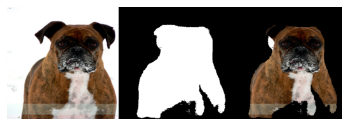

i= 2 loss= 0.46412121977435944 val_loss= 0.4473587650319804 mean_dsc= 0.8046709 val_mean_dsc= 0.82401145


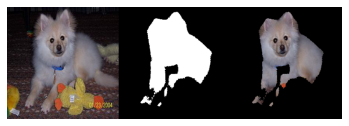

i= 3 loss= 0.3963092726115222 val_loss= 0.42256534358729486 mean_dsc= 0.8353537 val_mean_dsc= 0.8336767


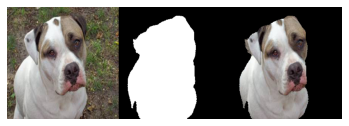

i= 4 loss= 0.35730646040341624 val_loss= 0.41070315630539606 mean_dsc= 0.8521423 val_mean_dsc= 0.83907


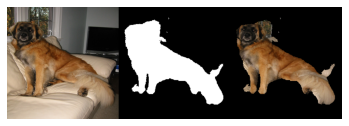

i= 5 loss= 0.3279754870218229 val_loss= 0.3671851870806321 mean_dsc= 0.8655504 val_mean_dsc= 0.860136


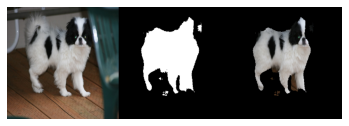

i= 6 loss= 0.2978706928692996 val_loss= 0.3551105727320132 mean_dsc= 0.87721336 val_mean_dsc= 0.857267


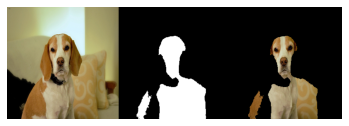

i= 7 loss= 0.27831398974678834 val_loss= 0.34258896889893903 mean_dsc= 0.8860538 val_mean_dsc= 0.86245626


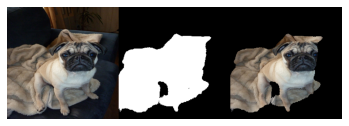

i= 8 loss= 0.2590111520940855 val_loss= 0.3029312238745067 mean_dsc= 0.8942303 val_mean_dsc= 0.8853976


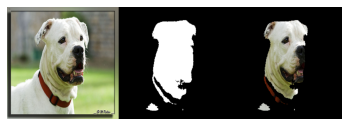

i= 9 loss= 0.2500392752082925 val_loss= 0.2998150755529818 mean_dsc= 0.89784133 val_mean_dsc= 0.88492316


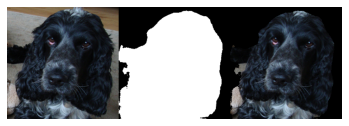

i= 10 loss= 0.2296123854373688 val_loss= 0.2854761377624843 mean_dsc= 0.9056813 val_mean_dsc= 0.88994956


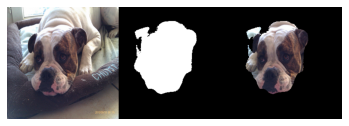

i= 11 loss= 0.21827336924669405 val_loss= 0.3089698268019635 mean_dsc= 0.91152257 val_mean_dsc= 0.883377


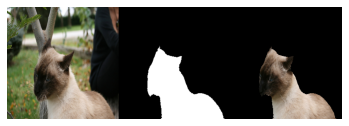

i= 12 loss= 0.20885765106846751 val_loss= 0.3004496402066687 mean_dsc= 0.91463643 val_mean_dsc= 0.88569295


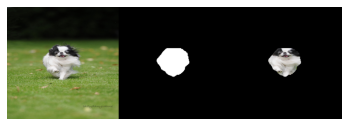

i= 13 loss= 0.20185968752729294 val_loss= 0.3025323405213978 mean_dsc= 0.91732186 val_mean_dsc= 0.88789195


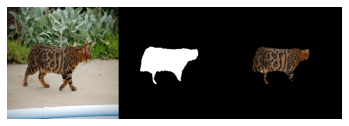

i= 14 loss= 0.19233384144972993 val_loss= 0.27545423611350683 mean_dsc= 0.9215002 val_mean_dsc= 0.89436495


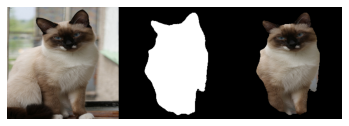

i= 15 loss= 0.18270355019055 val_loss= 0.35268041945022083 mean_dsc= 0.9248375 val_mean_dsc= 0.85697764


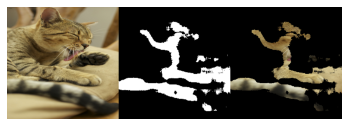

i= 16 loss= 0.17945140772010093 val_loss= 0.290391202206197 mean_dsc= 0.9267977 val_mean_dsc= 0.89519304


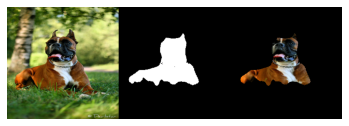

i= 17 loss= 0.16877576557400564 val_loss= 0.2795321189838907 mean_dsc= 0.9307934 val_mean_dsc= 0.8940197


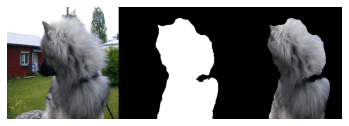

i= 18 loss= 0.16853479001688088 val_loss= 0.25540186076060584 mean_dsc= 0.93071204 val_mean_dsc= 0.9003685


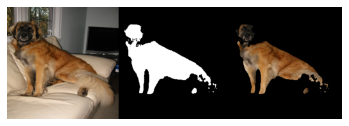

i= 19 loss= 0.16168758689880916 val_loss= 0.2890125979547915 mean_dsc= 0.9334754 val_mean_dsc= 0.8899474


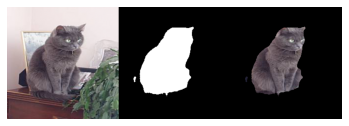

i= 20 loss= 0.1615784446534501 val_loss= 0.3050561527843061 mean_dsc= 0.9335546 val_mean_dsc= 0.89255905


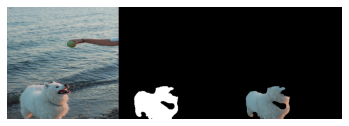

i= 21 loss= 0.14623362477443533 val_loss= 0.2915523842624996 mean_dsc= 0.9399216 val_mean_dsc= 0.8929557


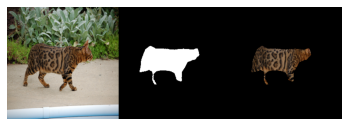

i= 22 loss= 0.15040085975029696 val_loss= 0.2847770426584327 mean_dsc= 0.93735194 val_mean_dsc= 0.8918362


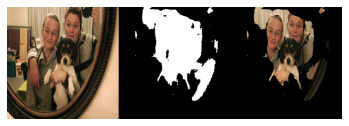

i= 23 loss= 0.14377134199760275 val_loss= 0.25653982486413873 mean_dsc= 0.94039714 val_mean_dsc= 0.90758115


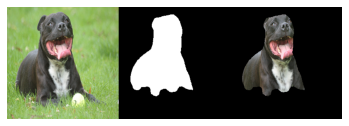

i= 24 loss= 0.1334529173938923 val_loss= 0.32280240499455 mean_dsc= 0.94492906 val_mean_dsc= 0.8795935


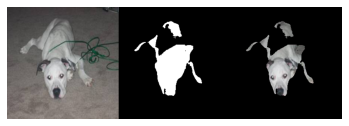

i= 25 loss= 0.1378310919318297 val_loss= 0.2833549399738726 mean_dsc= 0.9427239 val_mean_dsc= 0.8958607


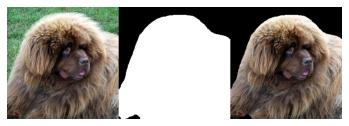

i= 26 loss= 0.13566115797926845 val_loss= 0.2544833052417506 mean_dsc= 0.9436329 val_mean_dsc= 0.90460736


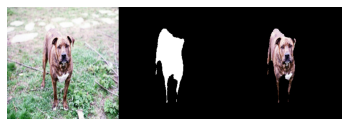

i= 27 loss= 0.13143403610410212 val_loss= 0.2935399095649305 mean_dsc= 0.94535756 val_mean_dsc= 0.89483947


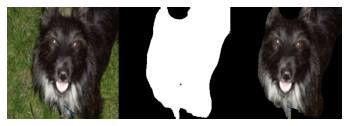

In [ ]:
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps, validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Testing

In [ ]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
# msk  = pred.squeeze()
# msk = np.stack((msk,)*3, axis=-1)
# msk[msk >= 0.5] = 1 
# msk[msk < 0.5] = 0 

msk = np.argmax(pred, axis=-1)
# (1, 256, 256)
msk  = msk.squeeze()
# (256, 256)
msk = np.stack((msk,)*3, axis=-1)
# (256, 256, 3)

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

